In [1]:
import torch
import pandas as pd
from torch_geometric.data import DataLoader, Batch, Data
from embedding import GNN
from downstream import MLP
from conexplainer import ContExplainer, MLPExplainer
from loader import MoleculeDataset
from splitters import scaffold_split
from dig.xgraph.evaluation import XCollector

from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG, display

device = torch.device("cuda:3" if torch.cuda.is_available() else torch.device("cpu"))

def get_task(idx):
    def transform(data):
        return Data(x=data.x, edge_index=data.edge_index, edge_attr=data.edge_attr, y=data.y[idx:idx+1].long())
    return transform

def get_dataset(name, task=0):
    task_transform = get_task(task)
    dataset = MoleculeDataset("dataset/%s"%name, dataset=name, transform=task_transform)
    smiles_list = pd.read_csv('dataset/%s/processed/smiles.csv'%name, header=None)[0].tolist()
    return dataset, smiles_list

In [31]:
embed_model = GNN(num_layer = 5, emb_dim = 600, JK = 'last', drop_ratio = 0, gnn_type = 'gin')
embed_model.load_state_dict(torch.load('ckpts_model/chem_pretrained_contextpred.pth', map_location='cpu'))
enc_explainer = ContExplainer(embed_model, embed_dim=600, device=device, explain_graph=True, 
                              grad_scale=0.2, coff_size=0.05, coff_ent=0.002, loss_type='JSE')

state_dict = torch.load('ckpts_explainer/explain_mol_twostage.pt')
enc_explainer.explainer.load_state_dict(state_dict)

<All keys matched successfully>

In [63]:
task_name = 'sider'
dataset, smiles_list = get_dataset(task_name)
mlp_model = MLP(num_layer = 2, emb_dim =600, hidden_dim = 600)
mlp_model.load_state_dict(torch.load('ckpts_model/downstream_%s_contextpred.pth'%task_name, map_location='cpu'))
mlp_explainer = MLPExplainer(mlp_model, device)

In [97]:
def visual_molecule(mid, cond=None):
    smiles = smiles_list[mid]
    mol = Chem.MolFromSmiles(smiles)
    
    data = Batch.from_data_list([dataset[mid]])
    top_k = max(1, int(data.edge_index.shape[1]*0.1))
    walks, masks, related_preds = \
        enc_explainer(data.to(device), mlp_explainer, top_k=top_k, mask_mode='split', cond_vec=cond)
    print(related_preds[0]['origin']-related_preds[0]['maskout'])
    highlights = torch.topk(masks[data.edge_index[0]>data.edge_index[1]], top_k)
    
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(280, 280)
    drawer.SetFontSize(1)

    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=highlights.indices.tolist())
    
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText().replace('svg:','')
    
    return svg

0.36984091997146606
tensor(312, device='cuda:3')


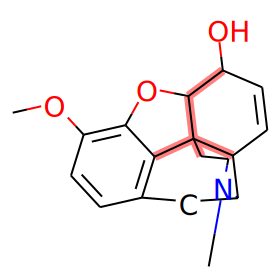

0.36559370160102844
tensor(320, device='cuda:3')


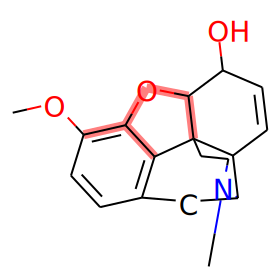

0.36559370160102844
tensor(86, device='cuda:3')


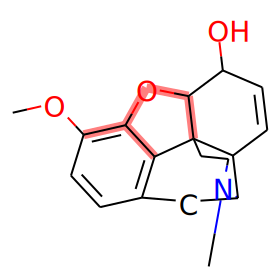

0.33056211471557617
tensor(568, device='cuda:3')


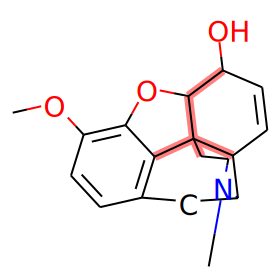

0.3305622339248657
tensor(414, device='cuda:3')


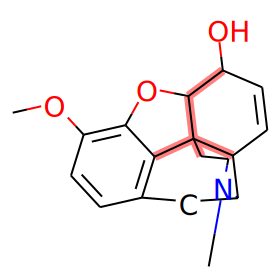

0.2509014904499054
tensor(334, device='cuda:3')


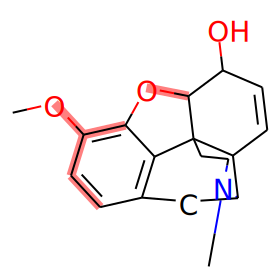

0.6797592490911484
tensor(55, device='cuda:3')


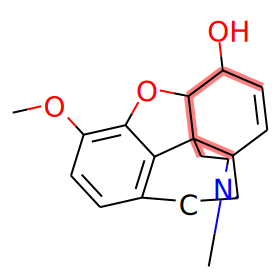

0.4669787287712097
tensor(286, device='cuda:3')


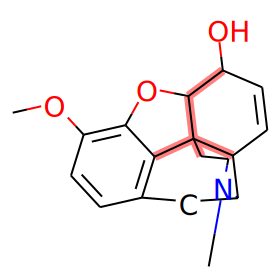

0.3305622935295105
tensor(413, device='cuda:3')


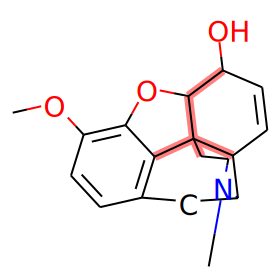

0.46697884798049927
tensor(183, device='cuda:3')


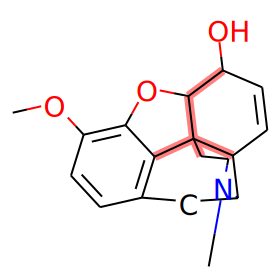

0.33056193590164185
tensor(89, device='cuda:3')


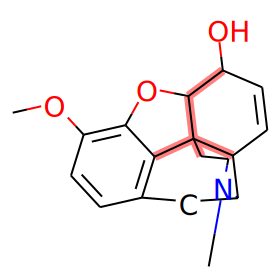

0.2398281693458557
tensor(481, device='cuda:3')


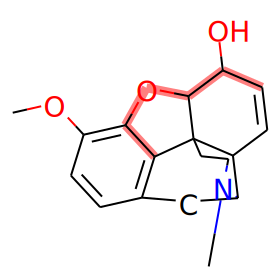

0.2652839124202728
tensor(159, device='cuda:3')


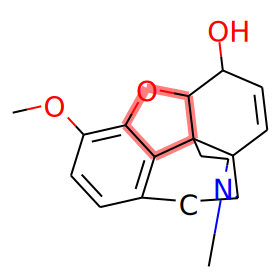

0.6642706990242004
tensor(341, device='cuda:3')


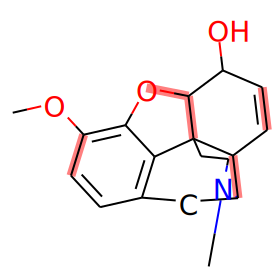

0.2652841806411743
tensor(216, device='cuda:3')


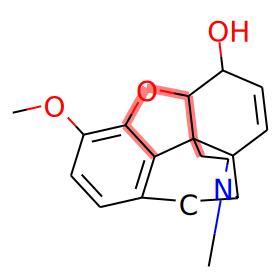

0.2652840316295624
tensor(560, device='cuda:3')


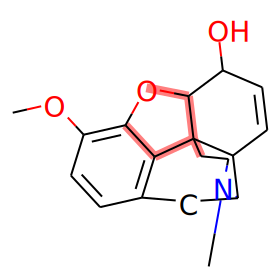

0.3305620551109314
tensor(41, device='cuda:3')


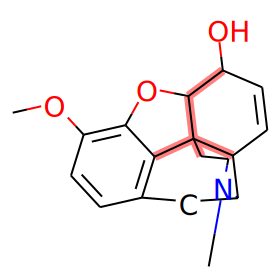

0.3205878436565399
tensor(503, device='cuda:3')


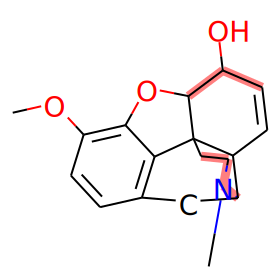

0.38223713636398315
tensor(496, device='cuda:3')


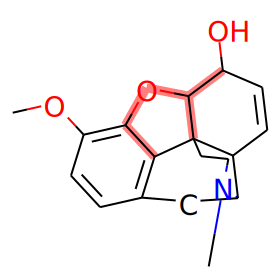

0.46697884798049927
tensor(356, device='cuda:3')


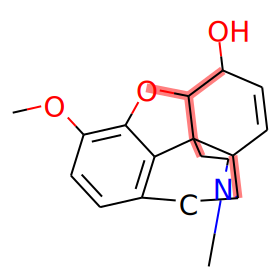

0.2652841806411743
tensor(205, device='cuda:3')


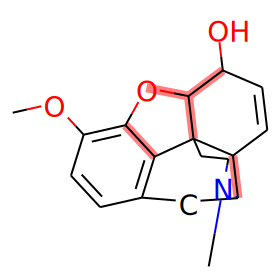

0.46697890758514404
tensor(345, device='cuda:3')


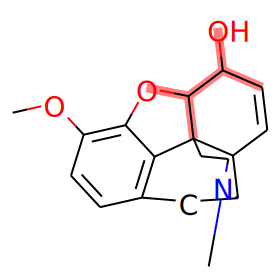

0.3655937910079956
tensor(444, device='cuda:3')


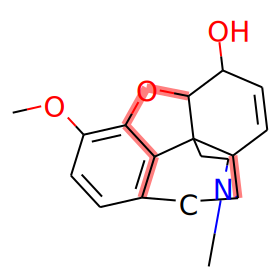

0.26528412103652954
tensor(227, device='cuda:3')


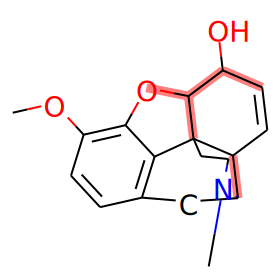

0.6797591373324394
tensor(46, device='cuda:3')


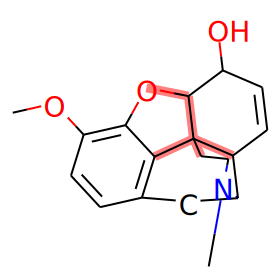

0.37040790915489197
tensor(499, device='cuda:3')


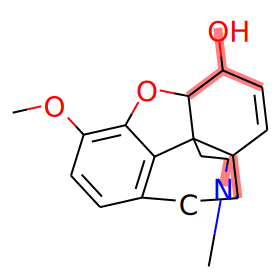

0.1826244592666626
tensor(326, device='cuda:3')


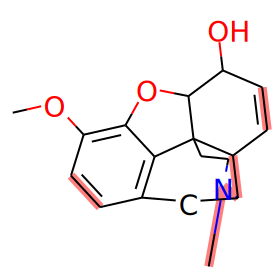

0.4669787585735321
tensor(390, device='cuda:3')


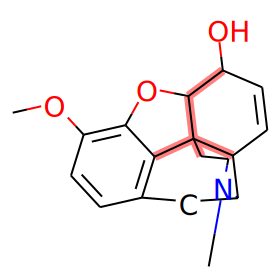

0.48635536432266235
tensor(360, device='cuda:3')


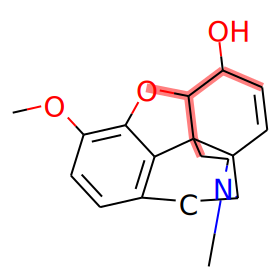

-0.13583868741989136
tensor(272, device='cuda:3')


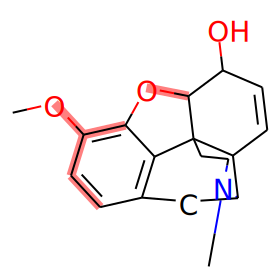

0.36984091997146606
tensor(36, device='cuda:3')


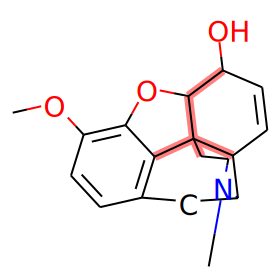

0.4669789671897888
tensor(256, device='cuda:3')


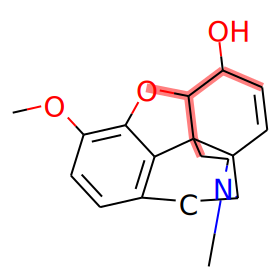

0.4669787883758545
tensor(423, device='cuda:3')


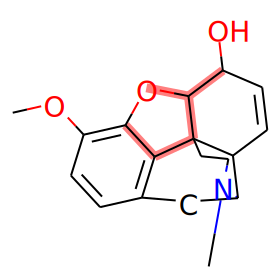

0.030135810375213623
tensor(56, device='cuda:3')


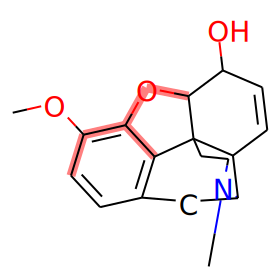

0.46697887778282166
tensor(330, device='cuda:3')


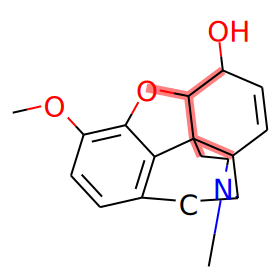

0.36984074115753174
tensor(258, device='cuda:3')


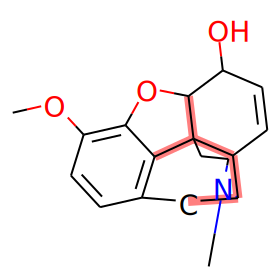

0.36984091997146606
tensor(470, device='cuda:3')


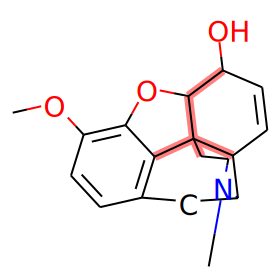

0.6797592341899872
tensor(582, device='cuda:3')


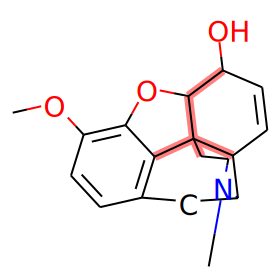

0.41776779294013977
tensor(575, device='cuda:3')


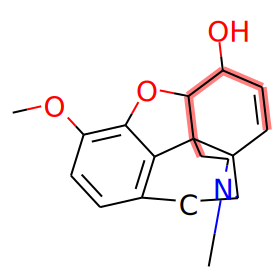

0.4669787287712097
tensor(445, device='cuda:3')


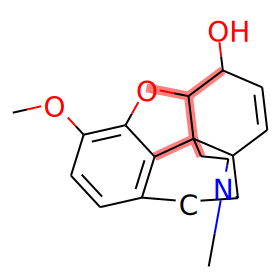

In [295]:
embed_model.eval()
data = Batch.from_data_list([dataset[82]])
topkd = embed_model(data.to(device)).topk(40)[1]

for did in topkd[0]:
    cond = torch.zeros([1, 600])
    cond[0, did] = 20
    svg = visual_molecule(82, cond=cond)
    print(did)
    display(SVG(svg))

0.46697887778282166


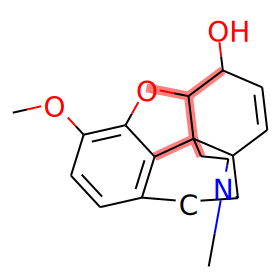

In [293]:
svg = visual_molecule(82)
SVG(svg)

0.18262434005737305


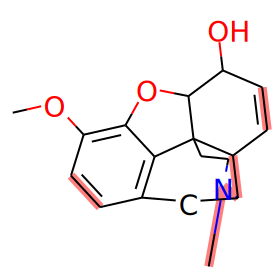

In [297]:
cond = torch.zeros([1, 600])
cond[0, 326] = 20
svg = visual_molecule(82, cond=cond)
SVG(svg)

0.2652842104434967


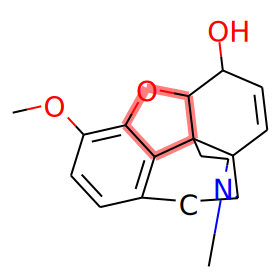

In [296]:
cond = torch.zeros([1, 600])
cond[0, 159] = 20
svg = visual_molecule(82, cond=cond)
SVG(svg)

0.640363484621048


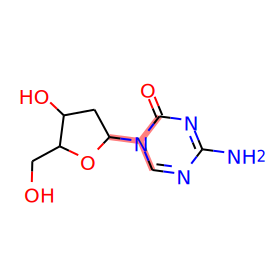

In [288]:
svg = visual_molecule(77)
SVG(svg)

0.640363484621048


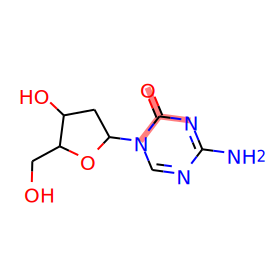

In [287]:
cond = torch.zeros([1, 600])
cond[0, 183] = 20
svg = visual_molecule(77, cond=cond)
SVG(svg)

0.00998830795288086


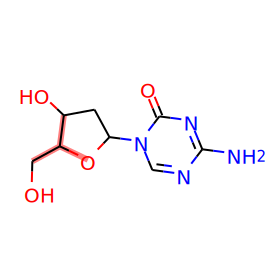

In [286]:
cond = torch.zeros([1, 600])
cond[0, 312] = 20
svg = visual_molecule(77, cond=cond)
SVG(svg)

0.3383241007104516


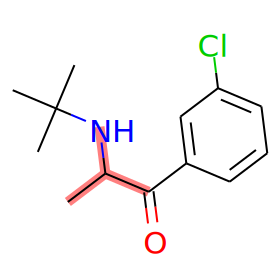

In [276]:
svg = visual_molecule(70)
SVG(svg)

0.0942009687423706


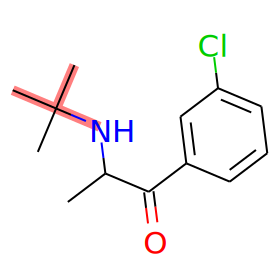

In [273]:
cond = torch.zeros([1, 600])
cond[0, 78] = 20
svg = visual_molecule(70, cond=cond)
SVG(svg)

0.08753925561904907


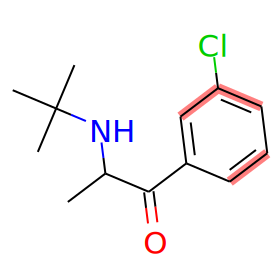

In [275]:
cond = torch.zeros([1, 600])
cond[0, 272] = 20
svg = visual_molecule(70, cond=cond)
SVG(svg)

0.8071910397848114


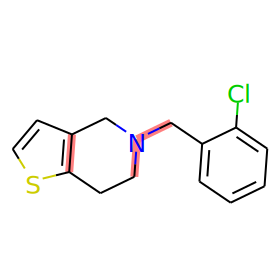

In [177]:
svg = visual_molecule(13)
SVG(svg)

In [178]:
embed_model.eval()
data = Batch.from_data_list([dataset[13]])
embed_model(data.to(device)).topk(40)[1]

tensor([[ 78, 312, 447, 334, 272,  86, 402, 320,  55, 326, 560, 496, 205, 444,
         445, 389,  56, 151, 218, 434,  41, 172, 515, 168, 342, 378,  32, 413,
         575, 307,  90, 481, 262,  27, 349, 525, 141, 403, 505, 535]],
       device='cuda:3')

0.3551807403564453


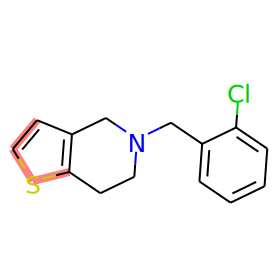

In [186]:
cond = torch.zeros([1, 600])
cond[0, 402] = 20
svg = visual_molecule(13, cond=cond)
SVG(svg)

0.0286596417427063


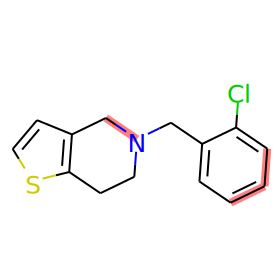

In [180]:
cond = torch.zeros([1, 600])
cond[0, 78] = 20
svg = visual_molecule(13, cond=cond)
SVG(svg)